Dhaivat Jani <br>
202511053

# Task 1 - Data Preparation

## Data Laoding

In [1]:
import pandas as pd

df = pd.read_csv('D:\College\DAU\Sem 02\Deep Learning\Lab02\MovieDataset\movies.csv')
df.shape

(4803, 24)

In [2]:
df.columns.to_list()

['index',
 'budget',
 'genres',
 'homepage',
 'id',
 'keywords',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'status',
 'tagline',
 'title',
 'vote_average',
 'vote_count',
 'cast',
 'crew',
 'director']

In [3]:
df = df[['overview', 'tagline', 'keywords', 'genres', 'vote_average']]
df.shape

(4803, 5)

## Preprocessing

### Null Values

In [4]:
df.isnull().sum()

overview          3
tagline         844
keywords        412
genres           28
vote_average      0
dtype: int64

In [5]:
df = df.dropna(subset=['genres', 'overview'])
df['tagline'] = df['tagline'].fillna('')
df['keywords'] = df['keywords'].fillna('')
df = df.reset_index(drop=True)

In [6]:
df.shape

(4772, 5)

### NLP Preprocessing

In [7]:
import re
import string

In [8]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\dhaiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhaiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhaiv\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#### For 'overview', 'tagline', 'keyword'

In [9]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [10]:
def preprocess_text(text):
    text = text.lower()

    text = re.sub(r'http\S+|www\S+', '', text)

    text = re.sub(r'\d+', '', text)
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = text.split()
    
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return tokens

In [11]:
df['overview_tokens'] = df['overview'].apply(preprocess_text)
df['tagline_tokens'] = df['tagline'].fillna('').apply(preprocess_text)
df['keywords_tokens'] = df['keywords'].fillna('').apply(preprocess_text)

#### For 'genres'

In [12]:
df['genres'] = df['genres'].str.replace("Science Fiction", "Science_Fiction")
df['genres'] = df['genres'].str.replace("TV Movie", "TV_Movie")

In [13]:
df['genres'] = df['genres'].apply(lambda x: x.split())

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
genre_encoded = mlb.fit_transform(df['genres'])
genre_df = pd.DataFrame(genre_encoded, columns=mlb.classes_)
df = pd.concat([df, genre_df], axis=1)

## Train-Val-Test Splitting 

In [15]:
from sklearn.model_selection import train_test_split

SEED = 42

train_df, temp_df = train_test_split(
    df, test_size=0.30, random_state=SEED
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.50, random_state=SEED
)

In [16]:
print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

Train size: 3340
Val size: 716
Test size: 716


# Task 2 - GloVe Embedding Pipeline 

## Load Embedding

In [17]:
import numpy as np

EMBEDDING_DIM = 100
glove_dict = {}

glove_path = "D:\College\DAU\Sem 02\Deep Learning\Lab02\glove.2024.wikigiga.100d\wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt"

with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        values = line.strip().split()
        
        if len(values) != EMBEDDING_DIM + 1:
            continue
        
        word = values[0]
        
        try:
            vector = np.asarray(values[1:], dtype='float32')
            glove_dict[word] = vector
        except ValueError:
            continue

print("Total GloVe words loaded:", len(glove_dict))

Total GloVe words loaded: 1287614


## Compute Embedding Coverage

In [18]:
all_tokens = set(
    token
    for tokens in df['overview_tokens']
    for token in tokens
)

print("Unique dataset tokens:", len(all_tokens))

Unique dataset tokens: 20632


In [19]:
covered_tokens = [
    token for token in all_tokens if token in glove_dict
]

coverage = len(covered_tokens) / len(all_tokens) * 100

print(f"GloVe Coverage: {coverage:.2f}%")

GloVe Coverage: 90.38%


## TF-IDF Vectorization & Embedding

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

def build_doc_embeddings(text_series, tfidf_vectorizer, glove_dict, dim):
    tfidf_matrix = tfidf_vectorizer.transform(text_series)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    embeddings = []
    
    for i in range(tfidf_matrix.shape[0]):
        row = tfidf_matrix[i]
        indices = row.indices
        data = row.data
        
        doc_vector = np.zeros(dim)
        weight_sum = 0
        
        for idx, tfidf_value in zip(indices, data):
            word = feature_names[idx]
            
            if word in glove_dict:
                doc_vector += glove_dict[word] * tfidf_value
                weight_sum += tfidf_value
        
        if weight_sum != 0:
            doc_vector = doc_vector / weight_sum
        
        embeddings.append(doc_vector)
    
    return np.array(embeddings)

### Overview

In [21]:
df['overview_clean'] = df['overview_tokens'].apply(lambda x: " ".join(x))

tfidf_overview = TfidfVectorizer(max_features=21000)
tfidf_overview.fit(df['overview_clean'])

overview_embeddings = build_doc_embeddings(
    df['overview_clean'],
    tfidf_overview,
    glove_dict,
    EMBEDDING_DIM
)

print("Overview embedding shape:", overview_embeddings.shape)

Overview embedding shape: (4772, 100)


### Tagline

In [22]:
df['tagline_clean'] = df['tagline_tokens'].apply(lambda x: " ".join(x))

tfidf_tagline = TfidfVectorizer(max_features=21000)
tfidf_tagline.fit(df['tagline_clean'])

tagline_embeddings = build_doc_embeddings(
    df['tagline_clean'],
    tfidf_tagline,
    glove_dict,
    EMBEDDING_DIM
)

print("Tagline embedding shape:", tagline_embeddings.shape)

Tagline embedding shape: (4772, 100)


### Keyword

In [23]:
df['keywords_clean'] = df['keywords_tokens'].apply(lambda x: " ".join(x))

tfidf_keywords = TfidfVectorizer(max_features=21000)
tfidf_keywords.fit(df['keywords_clean'])

keywords_embeddings = build_doc_embeddings(
    df['keywords_clean'],
    tfidf_keywords,
    glove_dict,
    EMBEDDING_DIM
)

print("Keywords embedding shape:", keywords_embeddings.shape)

Keywords embedding shape: (4772, 100)


# Task 3 - Model A: Rating Prediction (Regression)

## Model

In [24]:
import torch.nn as nn

class RatingRegressor(nn.Module):
    def __init__(self, input_dim):
        super(RatingRegressor, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        
        x = self.layer2(x)
        x = self.relu2(x)
        
        x = self.output_layer(x)
        
        return x

## Training Loop

In [25]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(model, train_loader, val_loader, optimizer, lossFun, device, epochs):
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        
        # ---- TRAIN ----
        model.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = lossFun(outputs, y_batch)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        
        # ---- VALIDATION ----
        model.eval()
        val_loss = 0
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                outputs = model(X_batch)
                loss = lossFun(outputs, y_batch)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        
        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}")
    
    return train_losses, val_losses

### Combined Function for all 3 features

In [37]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

def run_regression_experiment(embeddings, column_name):

    print(f"\n===== Running Regression for: {column_name} =====")
    
    # Split using saved indices
    X_train = torch.tensor(embeddings[train_df.index], dtype=torch.float32)
    X_val   = torch.tensor(embeddings[val_df.index], dtype=torch.float32)
    X_test  = torch.tensor(embeddings[test_df.index], dtype=torch.float32)

    y_train = torch.tensor(train_df['vote_average'].values, dtype=torch.float32).view(-1,1)
    y_val   = torch.tensor(val_df['vote_average'].values, dtype=torch.float32).view(-1,1)
    y_test  = torch.tensor(test_df['vote_average'].values, dtype=torch.float32).view(-1,1)

    # Dataloaders

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
    test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

    # Model
    model = RatingRegressor(input_dim=EMBEDDING_DIM).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    lossFun = torch.nn.MSELoss()

    # Train
    train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        optimizer, lossFun, device,
        epochs=50
    )

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title(f"Training vs Validation Loss ({column_name})")
    plt.legend()
    plt.show()

    # Test evaluation
    model.eval()
    predictions = []
    true_vals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            predictions.extend(outputs.cpu().numpy())
            true_vals.extend(y_batch.numpy())

    mse = mean_squared_error(true_vals, predictions)
    rmse = np.sqrt(mse)

    # Baseline
    global_mean = y_train.mean().item()
    baseline_preds = np.full_like(true_vals, global_mean)
    baseline_mse = mean_squared_error(true_vals, baseline_preds)
    baseline_rmse = np.sqrt(baseline_mse)

    print(f"{column_name} Test RMSE: {rmse:.4f}")
    print(f"{column_name} Baseline RMSE: {baseline_rmse:.4f}")

    return rmse, baseline_rmse

## Training & Evaluation

### For Overview


===== Running Regression for: Overview =====
Epoch 1/50 | Train Loss: 17.6533 | Val Loss: 2.4100
Epoch 2/50 | Train Loss: 2.2571 | Val Loss: 1.9623
Epoch 3/50 | Train Loss: 2.0343 | Val Loss: 1.7307
Epoch 4/50 | Train Loss: 1.9350 | Val Loss: 1.6776
Epoch 5/50 | Train Loss: 1.7529 | Val Loss: 1.5001
Epoch 6/50 | Train Loss: 1.6935 | Val Loss: 1.4497
Epoch 7/50 | Train Loss: 1.6326 | Val Loss: 1.4068
Epoch 8/50 | Train Loss: 1.5825 | Val Loss: 1.3824
Epoch 9/50 | Train Loss: 1.5425 | Val Loss: 1.3448
Epoch 10/50 | Train Loss: 1.5553 | Val Loss: 1.3395
Epoch 11/50 | Train Loss: 1.4680 | Val Loss: 1.3265
Epoch 12/50 | Train Loss: 1.4484 | Val Loss: 1.3008
Epoch 13/50 | Train Loss: 1.4487 | Val Loss: 1.2985
Epoch 14/50 | Train Loss: 1.4263 | Val Loss: 1.2506
Epoch 15/50 | Train Loss: 1.3922 | Val Loss: 1.2618
Epoch 16/50 | Train Loss: 1.3578 | Val Loss: 1.2496
Epoch 17/50 | Train Loss: 1.3940 | Val Loss: 1.2519
Epoch 18/50 | Train Loss: 1.3361 | Val Loss: 1.2322
Epoch 19/50 | Train Loss: 

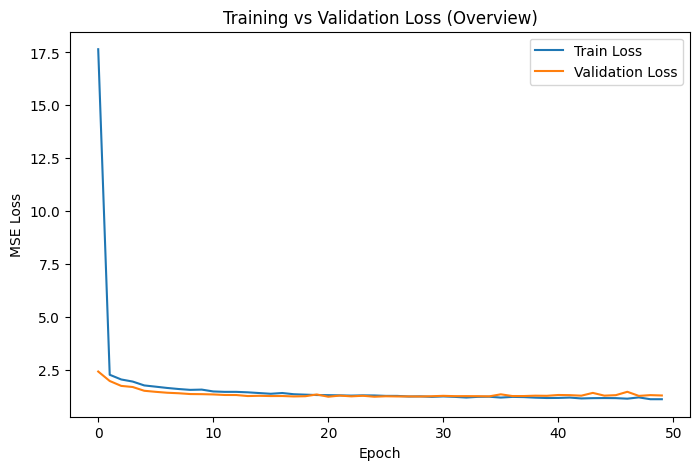

Overview Test RMSE: 1.1166
Overview Baseline RMSE: 1.1206


In [27]:
rmse_overview, base_overview = run_regression_experiment(
    overview_embeddings, "Overview"
)

### For Tagline


===== Running Regression for: Tagline =====
Epoch 1/50 | Train Loss: 19.2668 | Val Loss: 5.6837
Epoch 2/50 | Train Loss: 5.5101 | Val Loss: 3.3980
Epoch 3/50 | Train Loss: 2.9460 | Val Loss: 1.6433
Epoch 4/50 | Train Loss: 1.7043 | Val Loss: 1.3743
Epoch 5/50 | Train Loss: 1.6243 | Val Loss: 1.4093
Epoch 6/50 | Train Loss: 1.5776 | Val Loss: 1.3205
Epoch 7/50 | Train Loss: 1.4948 | Val Loss: 1.3098
Epoch 8/50 | Train Loss: 1.5718 | Val Loss: 1.3204
Epoch 9/50 | Train Loss: 1.4730 | Val Loss: 1.3704
Epoch 10/50 | Train Loss: 1.4786 | Val Loss: 1.3456
Epoch 11/50 | Train Loss: 1.4584 | Val Loss: 1.3223
Epoch 12/50 | Train Loss: 1.4347 | Val Loss: 1.3007
Epoch 13/50 | Train Loss: 1.4128 | Val Loss: 1.2994
Epoch 14/50 | Train Loss: 1.4190 | Val Loss: 1.2869
Epoch 15/50 | Train Loss: 1.4259 | Val Loss: 1.3068
Epoch 16/50 | Train Loss: 1.4388 | Val Loss: 1.3879
Epoch 17/50 | Train Loss: 1.4091 | Val Loss: 1.3212
Epoch 18/50 | Train Loss: 1.3750 | Val Loss: 1.3296
Epoch 19/50 | Train Loss: 1

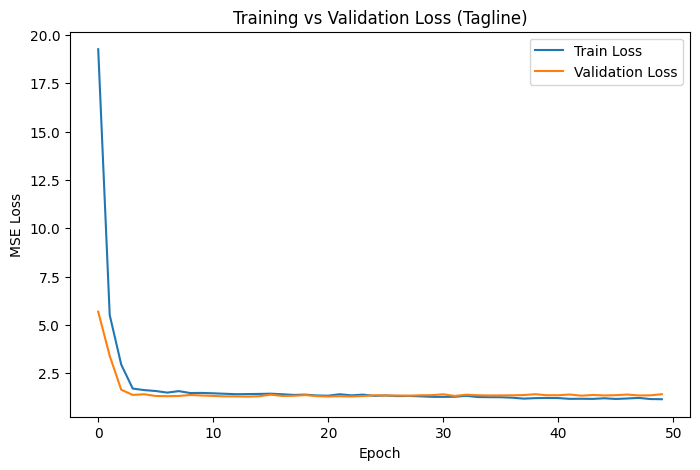

Tagline Test RMSE: 1.2082
Tagline Baseline RMSE: 1.1206


In [28]:
rmse_tagline, base_tagline = run_regression_experiment(
    tagline_embeddings, "Tagline"
)

### For Keyword


===== Running Regression for: Keywords =====
Epoch 1/50 | Train Loss: 17.5178 | Val Loss: 4.6069
Epoch 2/50 | Train Loss: 3.9560 | Val Loss: 3.4663
Epoch 3/50 | Train Loss: 3.0070 | Val Loss: 2.4334
Epoch 4/50 | Train Loss: 2.1745 | Val Loss: 1.7125
Epoch 5/50 | Train Loss: 1.6598 | Val Loss: 1.4507
Epoch 6/50 | Train Loss: 1.4977 | Val Loss: 1.3665
Epoch 7/50 | Train Loss: 1.4780 | Val Loss: 1.3369
Epoch 8/50 | Train Loss: 1.4536 | Val Loss: 1.3717
Epoch 9/50 | Train Loss: 1.4141 | Val Loss: 1.3159
Epoch 10/50 | Train Loss: 1.4382 | Val Loss: 1.3105
Epoch 11/50 | Train Loss: 1.4041 | Val Loss: 1.3009
Epoch 12/50 | Train Loss: 1.4175 | Val Loss: 1.2836
Epoch 13/50 | Train Loss: 1.4001 | Val Loss: 1.3560
Epoch 14/50 | Train Loss: 1.3821 | Val Loss: 1.2970
Epoch 15/50 | Train Loss: 1.3231 | Val Loss: 1.2939
Epoch 16/50 | Train Loss: 1.3546 | Val Loss: 1.2784
Epoch 17/50 | Train Loss: 1.3329 | Val Loss: 1.3123
Epoch 18/50 | Train Loss: 1.2886 | Val Loss: 1.3022
Epoch 19/50 | Train Loss: 

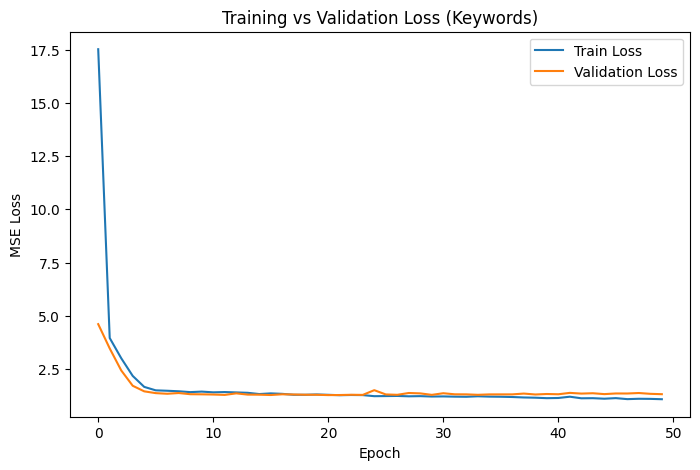

Keywords Test RMSE: 1.1047
Keywords Baseline RMSE: 1.1206


In [29]:
rmse_keywords, base_keywords = run_regression_experiment(
    keywords_embeddings, "Keywords"
)

### Result Comparison 

In [46]:
regression_comparison_df = pd.DataFrame({
    "Input Column": ["Overview", "Tagline", "Keywords"],
    "Test RMSE": [
        rmse_overview,
        rmse_tagline,
        rmse_keywords
    ],
    "Baseline RMSE": [
        base_overview,
        base_tagline,
        base_keywords
    ]
})

regression_comparison_df

,Input Column,Test RMSE,Baseline RMSE
0,Overview,1.116639,1.120576
1,Tagline,1.208198,1.120576
2,Keywords,1.104665,1.120576


# Task 4 - Model B: Genre Prediction (Multi-Label Classification)

## Distrubtion by Class

In [31]:
num_genres = genre_encoded.shape[1]
num_genres

20

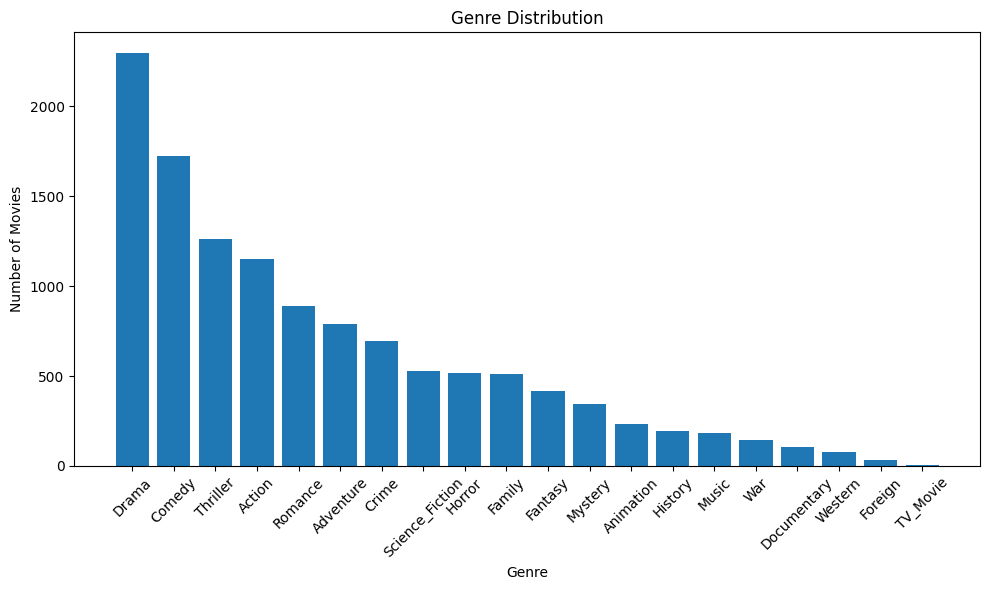

In [32]:
genre_counts = genre_encoded.sum(axis=0)

genre_distribution = pd.DataFrame({
    "Genre": mlb.classes_,
    "Number_of_Movies": genre_counts
}).sort_values(by="Number_of_Movies", ascending=False)

plt.figure(figsize=(10,6))
plt.bar(genre_distribution["Genre"], genre_distribution["Number_of_Movies"])
plt.xticks(rotation=45)
plt.xlabel("Genre")
plt.ylabel("Number of Movies")
plt.title("Genre Distribution")
plt.tight_layout()
plt.show()

## Model

In [ ]:
class GenreClassifier(nn.Module):
    def __init__(self, input_dim, num_labels):
        super().__init__()
        
        self.layer1 = nn.Linear(input_dim, 128)
        self.relu1 = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        
        self.layer2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        
        self.output = nn.Linear(64, num_labels)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu1(x)
        x = self.dropout(x)
        
        x = self.layer2(x)
        x = self.relu2(x)
        
        x = self.output(x) 
        return x

## Training & Evaluating

In [41]:
from sklearn.metrics import f1_score, hamming_loss, jaccard_score

def run_classification_experiment(embeddings, column_name):

    print(f"\n===== Running Classification for: {column_name} =====")

    # Input tensors
    X_train = torch.tensor(embeddings[train_df.index], dtype=torch.float32)
    X_val   = torch.tensor(embeddings[val_df.index], dtype=torch.float32)
    X_test  = torch.tensor(embeddings[test_df.index], dtype=torch.float32)

    # Label tensors
    y_train = torch.tensor(genre_encoded[train_df.index], dtype=torch.float32)
    y_val   = torch.tensor(genre_encoded[val_df.index], dtype=torch.float32)
    y_test  = torch.tensor(genre_encoded[test_df.index], dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=64, shuffle=True)
    val_loader   = DataLoader(TensorDataset(X_val, y_val), batch_size=64)
    test_loader  = DataLoader(TensorDataset(X_test, y_test), batch_size=64)

    model = GenreClassifier(EMBEDDING_DIM, genre_encoded.shape[1]).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    lossFun = nn.BCEWithLogitsLoss()

    train_losses, val_losses = train_model(
        model, train_loader, val_loader,
        optimizer, lossFun, device,
        epochs=50
    )

    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.title(f"Training vs Validation Loss ({column_name})")
    plt.legend()
    plt.show()

    # Evaluation
    model.eval()
    preds = []
    true_vals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.sigmoid(outputs)
            preds.extend(probs.cpu().numpy())
            true_vals.extend(y_batch.numpy())

    preds = np.array(preds)
    true_vals = np.array(true_vals)

    preds_binary = (preds >= 0.5).astype(int)

    micro_f1 = f1_score(true_vals, preds_binary, average='micro')
    macro_f1 = f1_score(true_vals, preds_binary, average='macro')
    h_loss = hamming_loss(true_vals, preds_binary)
    jaccard = jaccard_score(true_vals, preds_binary, average='samples')

    print(f"{column_name} Micro-F1: {micro_f1:.4f}")
    print(f"{column_name} Macro-F1: {macro_f1:.4f}")
    print(f"{column_name} Hamming Loss: {h_loss:.4f}")
    print(f"{column_name} Jaccard Score: {jaccard:.4f}")

    return micro_f1, macro_f1, h_loss, jaccard

### For Overview


===== Running Classification for: Overview =====
Epoch 1/50 | Train Loss: 0.4680 | Val Loss: 0.3214
Epoch 2/50 | Train Loss: 0.3118 | Val Loss: 0.3033
Epoch 3/50 | Train Loss: 0.2919 | Val Loss: 0.2837
Epoch 4/50 | Train Loss: 0.2768 | Val Loss: 0.2721
Epoch 5/50 | Train Loss: 0.2672 | Val Loss: 0.2661
Epoch 6/50 | Train Loss: 0.2585 | Val Loss: 0.2572
Epoch 7/50 | Train Loss: 0.2543 | Val Loss: 0.2530
Epoch 8/50 | Train Loss: 0.2475 | Val Loss: 0.2498
Epoch 9/50 | Train Loss: 0.2464 | Val Loss: 0.2464
Epoch 10/50 | Train Loss: 0.2440 | Val Loss: 0.2454
Epoch 11/50 | Train Loss: 0.2423 | Val Loss: 0.2438
Epoch 12/50 | Train Loss: 0.2392 | Val Loss: 0.2422
Epoch 13/50 | Train Loss: 0.2388 | Val Loss: 0.2414
Epoch 14/50 | Train Loss: 0.2370 | Val Loss: 0.2396
Epoch 15/50 | Train Loss: 0.2351 | Val Loss: 0.2398
Epoch 16/50 | Train Loss: 0.2338 | Val Loss: 0.2382
Epoch 17/50 | Train Loss: 0.2328 | Val Loss: 0.2376
Epoch 18/50 | Train Loss: 0.2314 | Val Loss: 0.2372
Epoch 19/50 | Train Los

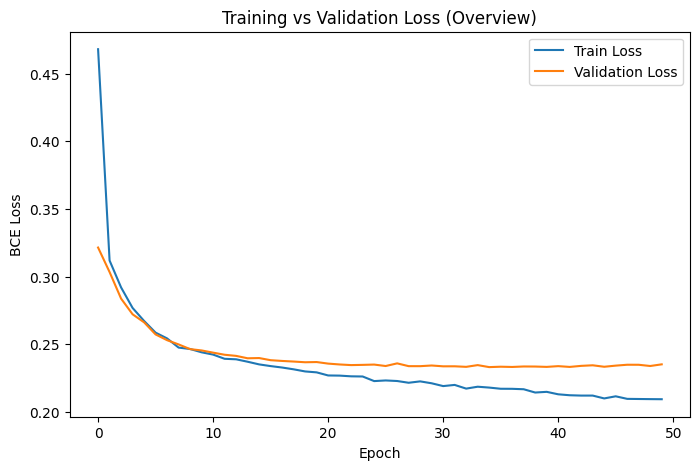

Overview Micro-F1: 0.5601
Overview Macro-F1: 0.3980
Overview Hamming Loss: 0.0957
Overview Jaccard Score: 0.4397


In [42]:
results_overview = run_classification_experiment(overview_embeddings, "Overview")

### For Tagline


===== Running Classification for: Tagline =====
Epoch 1/50 | Train Loss: 0.4862 | Val Loss: 0.3573
Epoch 2/50 | Train Loss: 0.3428 | Val Loss: 0.3249
Epoch 3/50 | Train Loss: 0.3155 | Val Loss: 0.3127
Epoch 4/50 | Train Loss: 0.3064 | Val Loss: 0.3075
Epoch 5/50 | Train Loss: 0.2995 | Val Loss: 0.3057
Epoch 6/50 | Train Loss: 0.2959 | Val Loss: 0.3036
Epoch 7/50 | Train Loss: 0.2934 | Val Loss: 0.3021
Epoch 8/50 | Train Loss: 0.2912 | Val Loss: 0.3012
Epoch 9/50 | Train Loss: 0.2891 | Val Loss: 0.3004
Epoch 10/50 | Train Loss: 0.2869 | Val Loss: 0.2995
Epoch 11/50 | Train Loss: 0.2854 | Val Loss: 0.2995
Epoch 12/50 | Train Loss: 0.2844 | Val Loss: 0.2987
Epoch 13/50 | Train Loss: 0.2816 | Val Loss: 0.2986
Epoch 14/50 | Train Loss: 0.2798 | Val Loss: 0.2986
Epoch 15/50 | Train Loss: 0.2794 | Val Loss: 0.2993
Epoch 16/50 | Train Loss: 0.2781 | Val Loss: 0.2987
Epoch 17/50 | Train Loss: 0.2783 | Val Loss: 0.2988
Epoch 18/50 | Train Loss: 0.2754 | Val Loss: 0.2989
Epoch 19/50 | Train Loss

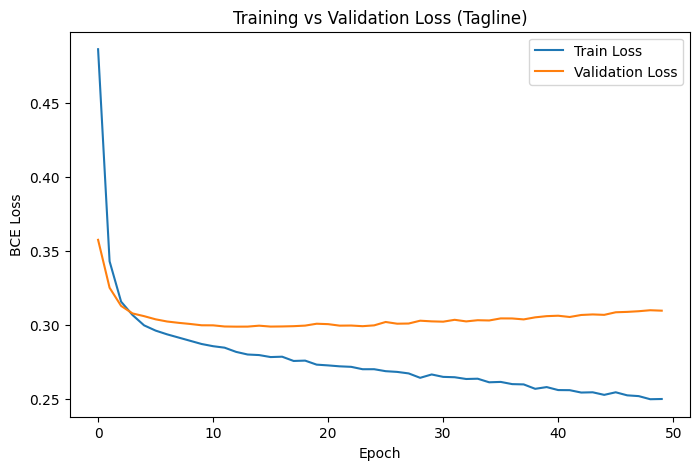

Tagline Micro-F1: 0.3438
Tagline Macro-F1: 0.1545
Tagline Hamming Loss: 0.1207
Tagline Jaccard Score: 0.2579


In [43]:
results_tagline = run_classification_experiment(tagline_embeddings, "Tagline")

### For Keyword


===== Running Classification for: Keywords =====
Epoch 1/50 | Train Loss: 0.4695 | Val Loss: 0.3406
Epoch 2/50 | Train Loss: 0.3254 | Val Loss: 0.3136
Epoch 3/50 | Train Loss: 0.2983 | Val Loss: 0.2885
Epoch 4/50 | Train Loss: 0.2810 | Val Loss: 0.2773
Epoch 5/50 | Train Loss: 0.2721 | Val Loss: 0.2718
Epoch 6/50 | Train Loss: 0.2656 | Val Loss: 0.2697
Epoch 7/50 | Train Loss: 0.2616 | Val Loss: 0.2662
Epoch 8/50 | Train Loss: 0.2578 | Val Loss: 0.2640
Epoch 9/50 | Train Loss: 0.2554 | Val Loss: 0.2623
Epoch 10/50 | Train Loss: 0.2549 | Val Loss: 0.2616
Epoch 11/50 | Train Loss: 0.2529 | Val Loss: 0.2619
Epoch 12/50 | Train Loss: 0.2514 | Val Loss: 0.2605
Epoch 13/50 | Train Loss: 0.2496 | Val Loss: 0.2604
Epoch 14/50 | Train Loss: 0.2483 | Val Loss: 0.2607
Epoch 15/50 | Train Loss: 0.2458 | Val Loss: 0.2597
Epoch 16/50 | Train Loss: 0.2443 | Val Loss: 0.2604
Epoch 17/50 | Train Loss: 0.2456 | Val Loss: 0.2600
Epoch 18/50 | Train Loss: 0.2439 | Val Loss: 0.2599
Epoch 19/50 | Train Los

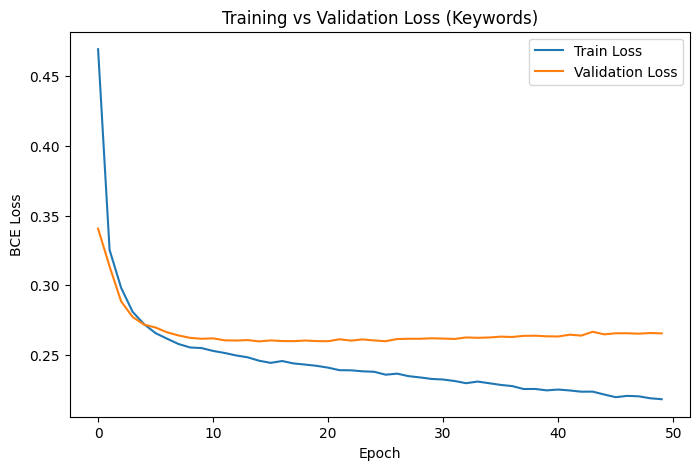

Keywords Micro-F1: 0.4966
Keywords Macro-F1: 0.3609
Keywords Hamming Loss: 0.1022
Keywords Jaccard Score: 0.3636


In [44]:
results_keywords = run_classification_experiment(keywords_embeddings, "Keywords")

### Result Comparison 

In [45]:
comparison_df = pd.DataFrame({
    "Input Column": ["Overview", "Tagline", "Keywords"],
    "Micro-F1": [
        results_overview[0],
        results_tagline[0],
        results_keywords[0]
    ],
    "Macro-F1": [
        results_overview[1],
        results_tagline[1],
        results_keywords[1]
    ],
    "Hamming Loss": [
        results_overview[2],
        results_tagline[2],
        results_keywords[2]
    ],
    "Jaccard Score": [
        results_overview[3],
        results_tagline[3],
        results_keywords[3]
    ]
})

comparison_df

,Input Column,Micro-F1,Macro-F1,Hamming Loss,Jaccard Score
0,Overview,0.560051,0.398033,0.095670,0.439728
1,Tagline,0.343833,0.154472,0.120740,0.257926
2,Keywords,0.496561,0.360853,0.102235,0.363644


# Task 5 - Frequent Words per Genre 

In [47]:
from collections import defaultdict, Counter

genre_word_dict = defaultdict(list)

for idx, row in df.iterrows():
    tokens = row['overview_tokens']
    genres = row['genres'] 
    
    for genre in genres:
        genre_word_dict[genre].extend(tokens)

## Top & Bottom 10

In [48]:
genre_top_bottom = {}

for genre, words in genre_word_dict.items():
    
    word_counts = Counter(words)
    
    filtered_counts = {w: c for w, c in word_counts.items() if c >= 3}
    
    sorted_words = sorted(filtered_counts.items(), key=lambda x: x[1], reverse=True)
    
    top_10 = sorted_words[:10]
    bottom_10 = sorted_words[-10:] if len(sorted_words) >= 10 else sorted_words
    
    genre_top_bottom[genre] = {
        "Top 10": top_10,
        "Bottom 10": bottom_10
    }

In [49]:
for genre in sorted(genre_top_bottom.keys()):
    
    print(f"\n===== {genre} =====")
    
    print("\nTop 10 Words:")
    for word, count in genre_top_bottom[genre]["Top 10"]:
        print(f"{word}: {count}")
    
    print("\nBottom 10 Words (freq ≥ 3):")
    for word, count in genre_top_bottom[genre]["Bottom 10"]:
        print(f"{word}: {count}")


===== Action =====

Top 10 Words:
find: 187
world: 185
life: 168
one: 166
must: 165
new: 160
man: 134
two: 130
take: 126
get: 119

Bottom 10 Words (freq ≥ 3):
stagecoach: 3
gasoline: 3
hazen: 3
stegman: 3
entei: 3
evening: 3
fred: 3
reagan: 3
wiley: 3
guitar: 3

===== Adventure =====

Top 10 Words:
world: 173
find: 172
life: 124
new: 124
must: 122
one: 107
young: 105
two: 95
take: 86
friend: 82

Bottom 10 Words (freq ≥ 3):
deke: 3
hazen: 3
taylor: 3
entei: 3
mcmaster: 3
goon: 3
herzog: 3
loch: 3
ness: 3
wiley: 3

===== Animation =====

Top 10 Words:
world: 68
find: 59
new: 52
life: 50
friend: 43
one: 40
get: 39
adventure: 39
must: 39
young: 36

Bottom 10 Words (freq ≥ 3):
humphrey: 3
anything: 3
kai: 3
recess: 3
episode: 3
brendan: 3
kaneda: 3
digimon: 3
parrotmon: 3
entei: 3

===== Comedy =====

Top 10 Words:
life: 380
find: 301
new: 286
friend: 278
get: 269
one: 266
two: 222
love: 213
family: 191
man: 185

Bottom 10 Words (freq ≥ 3):
kirby: 3
herzog: 3
loch: 3
ness: 3
wiley: 3
carli

# Task 6 - Genre-Indicative Words Using TF-IDF

In [52]:
tfidf_task6 = TfidfVectorizer(
    max_features=21000,
    min_df=3
)

X_tfidf = tfidf_task6.fit_transform(df['overview_clean'])
feature_names = tfidf_task6.get_feature_names_out()

## Logistic Regression

In [53]:
from sklearn.linear_model import LogisticRegression

indicative_words = {}

for i, genre in enumerate(mlb.classes_):
    
    print(f"Training Logistic Regression for {genre}...")
    
    y_genre = genre_encoded[:, i]
    
    clf = LogisticRegression(max_iter=2000)
    clf.fit(X_tfidf, y_genre)
    
    # Get coefficients
    coefs = clf.coef_[0]
    
    # Get top 10 positive words
    top_indices = coefs.argsort()[-10:][::-1]
    
    top_words = [feature_names[idx] for idx in top_indices]
    
    indicative_words[genre] = top_words

Training Logistic Regression for Action...
Training Logistic Regression for Adventure...
Training Logistic Regression for Animation...
Training Logistic Regression for Comedy...
Training Logistic Regression for Crime...
Training Logistic Regression for Documentary...
Training Logistic Regression for Drama...
Training Logistic Regression for Family...
Training Logistic Regression for Fantasy...
Training Logistic Regression for Foreign...
Training Logistic Regression for History...
Training Logistic Regression for Horror...
Training Logistic Regression for Music...
Training Logistic Regression for Mystery...
Training Logistic Regression for Romance...
Training Logistic Regression for Science_Fiction...
Training Logistic Regression for TV_Movie...
Training Logistic Regression for Thriller...
Training Logistic Regression for War...
Training Logistic Regression for Western...


## Results

In [54]:
for genre, words in indicative_words.items():
    print(f"\n===== {genre} =====")
    print("Indicative Words:", ", ".join(words))


===== Action =====
Indicative Words: cop, agent, hero, assassin, criminal, warrior, target, ruthless, fight, mission

===== Adventure =====
Indicative Words: adventure, bond, jungle, world, power, warrior, mission, force, save, dinosaur

===== Animation =====
Indicative Words: adventure, animated, human, world, penguin, monster, shrek, save, named, dragon

===== Comedy =====
Indicative Words: comedy, guy, wedding, big, show, movie, doesnt, single, christmas, girlfriend

===== Crime =====
Indicative Words: police, cop, drug, murder, detective, criminal, fbi, gangster, mafia, killer

===== Documentary =====
Indicative Words: documentary, look, filmmaker, film, interview, footage, global, tour, american, michael

===== Drama =====
Indicative Words: story, life, drama, struggle, wife, love, mother, family, war, change

===== Family =====
Indicative Words: adventure, dog, boy, save, world, land, christmas, named, kid, animal

===== Fantasy =====
Indicative Words: evil, power, vampire, king